# Exploring the Weather in Athens

In this data analysis, we explore the weather in Athens over a period of more than 50 years.

---

> Stamatia Papageorgiou, 8180091 <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> t8180091@aueb.gr <br />
> Date: November 2021

The data we used regarding the weather in Athens, were obtained from two different sources.
1. First, we downloaded the meteorological data referring the period of 1955-2020 from the [National Oceanic and Atmospheric Administration's National Centers for Environmental Information](https://www.ncdc.noaa.gov/cdo-web/). <br />
2. Then we used the meteorological data for the period of 2010-2019, obtained from the [National Observatory of Athens Institute of Environmental Research and Sustainable Development](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f), to fill in any missing data.

## Reading our Data 

- In order to analyze the weather in Athens, we specifically used the data from the Hellinikon weather station. <br />
- We first focused on data regarding the temperature of Athens over the years. 

In [1]:
import pandas as pd
import numpy as np

data1_filename = "data/athens_1955_2020.csv"
data1 = pd.read_csv(data1_filename, parse_dates=['DATE'])
data_hel = data1.loc[data1.NAME=='HELLINIKON, GR']
data1_temp = data_hel[['DATE', 'TAVG', 'TMAX', 'TMIN']]
pd.to_datetime(data1_temp["DATE"])
data1_temp = data1_temp.set_index('DATE')
data1_temp

,TAVG,TMAX,TMIN
DATE,,,
1955-01-01,NaN,65.0,50.0
1955-01-02,NaN,58.0,45.0
1955-01-03,NaN,60.0,49.0
1955-01-04,NaN,66.0,45.0
1955-01-05,NaN,64.0,47.0
...,...,...,...
2020-12-27,62.0,NaN,NaN
2020-12-28,59.0,65.0,53.0
2020-12-29,61.0,68.0,54.0


In [2]:
data2_filename = "data/athens.csv"
headers = ['DATE', 'MEAN_TEMP', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_HUMIDITY', 'MAX_HUMIDITY', 'MIN_HUMIDITY', 'MEAN_ATM_PRESSURE', 'MAX_ATM_PRESSURE', 'MIN_ATM_PRESSURE', 'PRCP', 'MEAN_WIND_SPEED', 'WIND_DIRECTION', 'WIND_GUST']
data2 = pd.read_csv(data2_filename, parse_dates=['DATE'], names=headers)
data2_temp = data2[['DATE', 'MEAN_TEMP', 'MAX_TEMP', 'MIN_TEMP']].set_index('DATE')
data2_temp

,MEAN_TEMP,MAX_TEMP,MIN_TEMP
DATE,,,
2010-01-01,17.9,18.1,17.8
2010-01-02,15.6,15.7,15.5
2010-01-03,13.5,13.6,13.4
2010-01-04,9.5,9.6,9.5
2010-01-05,13.4,13.5,13.4
...,...,...,...
2019-12-27,10.1,10.2,10.0
2019-12-28,8.3,8.4,8.2
2019-12-29,6.4,6.5,6.4


## Some things to take into consideration
- For better understanding, we converted all temperatures to Celcius.
- We filled in any missing values concerning the maximum, minimum and average daily temperature by combining both datasets.
- For the days where we had the maximum and minimum temperature, but the average was missing, we calculated it using: <br />
<img src="https://latex.codecogs.com/gif.latex?\frac{max&space;&plus;&space;min}{2}" title="\frac{max + min}{2}" align="center" />


In [3]:
data1_temp = ((data1_temp - 32) / 1.8).round(1)
all_daily_temp = pd.concat([data1_temp, data2_temp], axis=1)  #combine both datasets
all_daily_temp = all_daily_temp.apply(pd.to_numeric, errors="coerce")
all_daily_temp.TMIN.fillna(all_daily_temp.MIN_TEMP, inplace=True) #fill in minimum temperature
all_daily_temp.TMAX.fillna(all_daily_temp.MAX_TEMP, inplace=True) #fill in maximum temperature
all_daily_temp.TAVG.fillna(all_daily_temp.MEAN_TEMP, inplace=True) #fill in average temperature
all_daily_temp = all_daily_temp.drop(["MEAN_TEMP", "MAX_TEMP", "MIN_TEMP"], axis=1)
all_daily_temp.TAVG[all_daily_temp.TAVG.isna()] = ((all_daily_temp.TMAX + all_daily_temp.TMIN) /2).round(1)
all_daily_temp = all_daily_temp.drop(labels=["TMIN", "TMAX"], axis=1)
all_daily_temp

,TAVG
DATE,
1955-01-01,14.2
1955-01-02,10.8
1955-01-03,12.5
1955-01-04,13.0
1955-01-05,13.0
...,...
2020-12-27,16.7
2020-12-28,15.0
2020-12-29,16.1


Using as a baseline the period of 1974-1999, we compared the mean temperature during the summer season for each year from 1955 until 2020 with the mean summer temperature of the baseline.

In [4]:
import matplotlib.pyplot as plt

all_daily_temp = all_daily_temp.reset_index()
all_daily_temp["month"] = all_daily_temp["DATE"].dt.month
all_daily_temp["year"] = all_daily_temp["DATE"].dt.year

average = all_daily_temp.groupby(["month","year"]).mean()
average = average.reset_index()
baseline_avg = average.loc[(average.year>=1974) & (average.year<=1999) & (average.month>=6) 
                                       & (average.month<=8)].TAVG.mean()
summers = average.loc[(average.month>=6) & (average.month<=8)]
summers_avg = summers.groupby(["year"]).mean().drop(["month"], axis=1)
summers_avg["deviation"] = summers_avg - baseline_avg
summers_avg["rolling_avg"] = summers_avg.rolling(10, min_periods=1).mean().deviation
summers_avg = summers_avg.reset_index()

The following graph shows for each year, the mean summer temperature deviation from the baseline of 1974-1999 and the line that runs through the graph is the 10 years rolling average of the deviation from the mean.

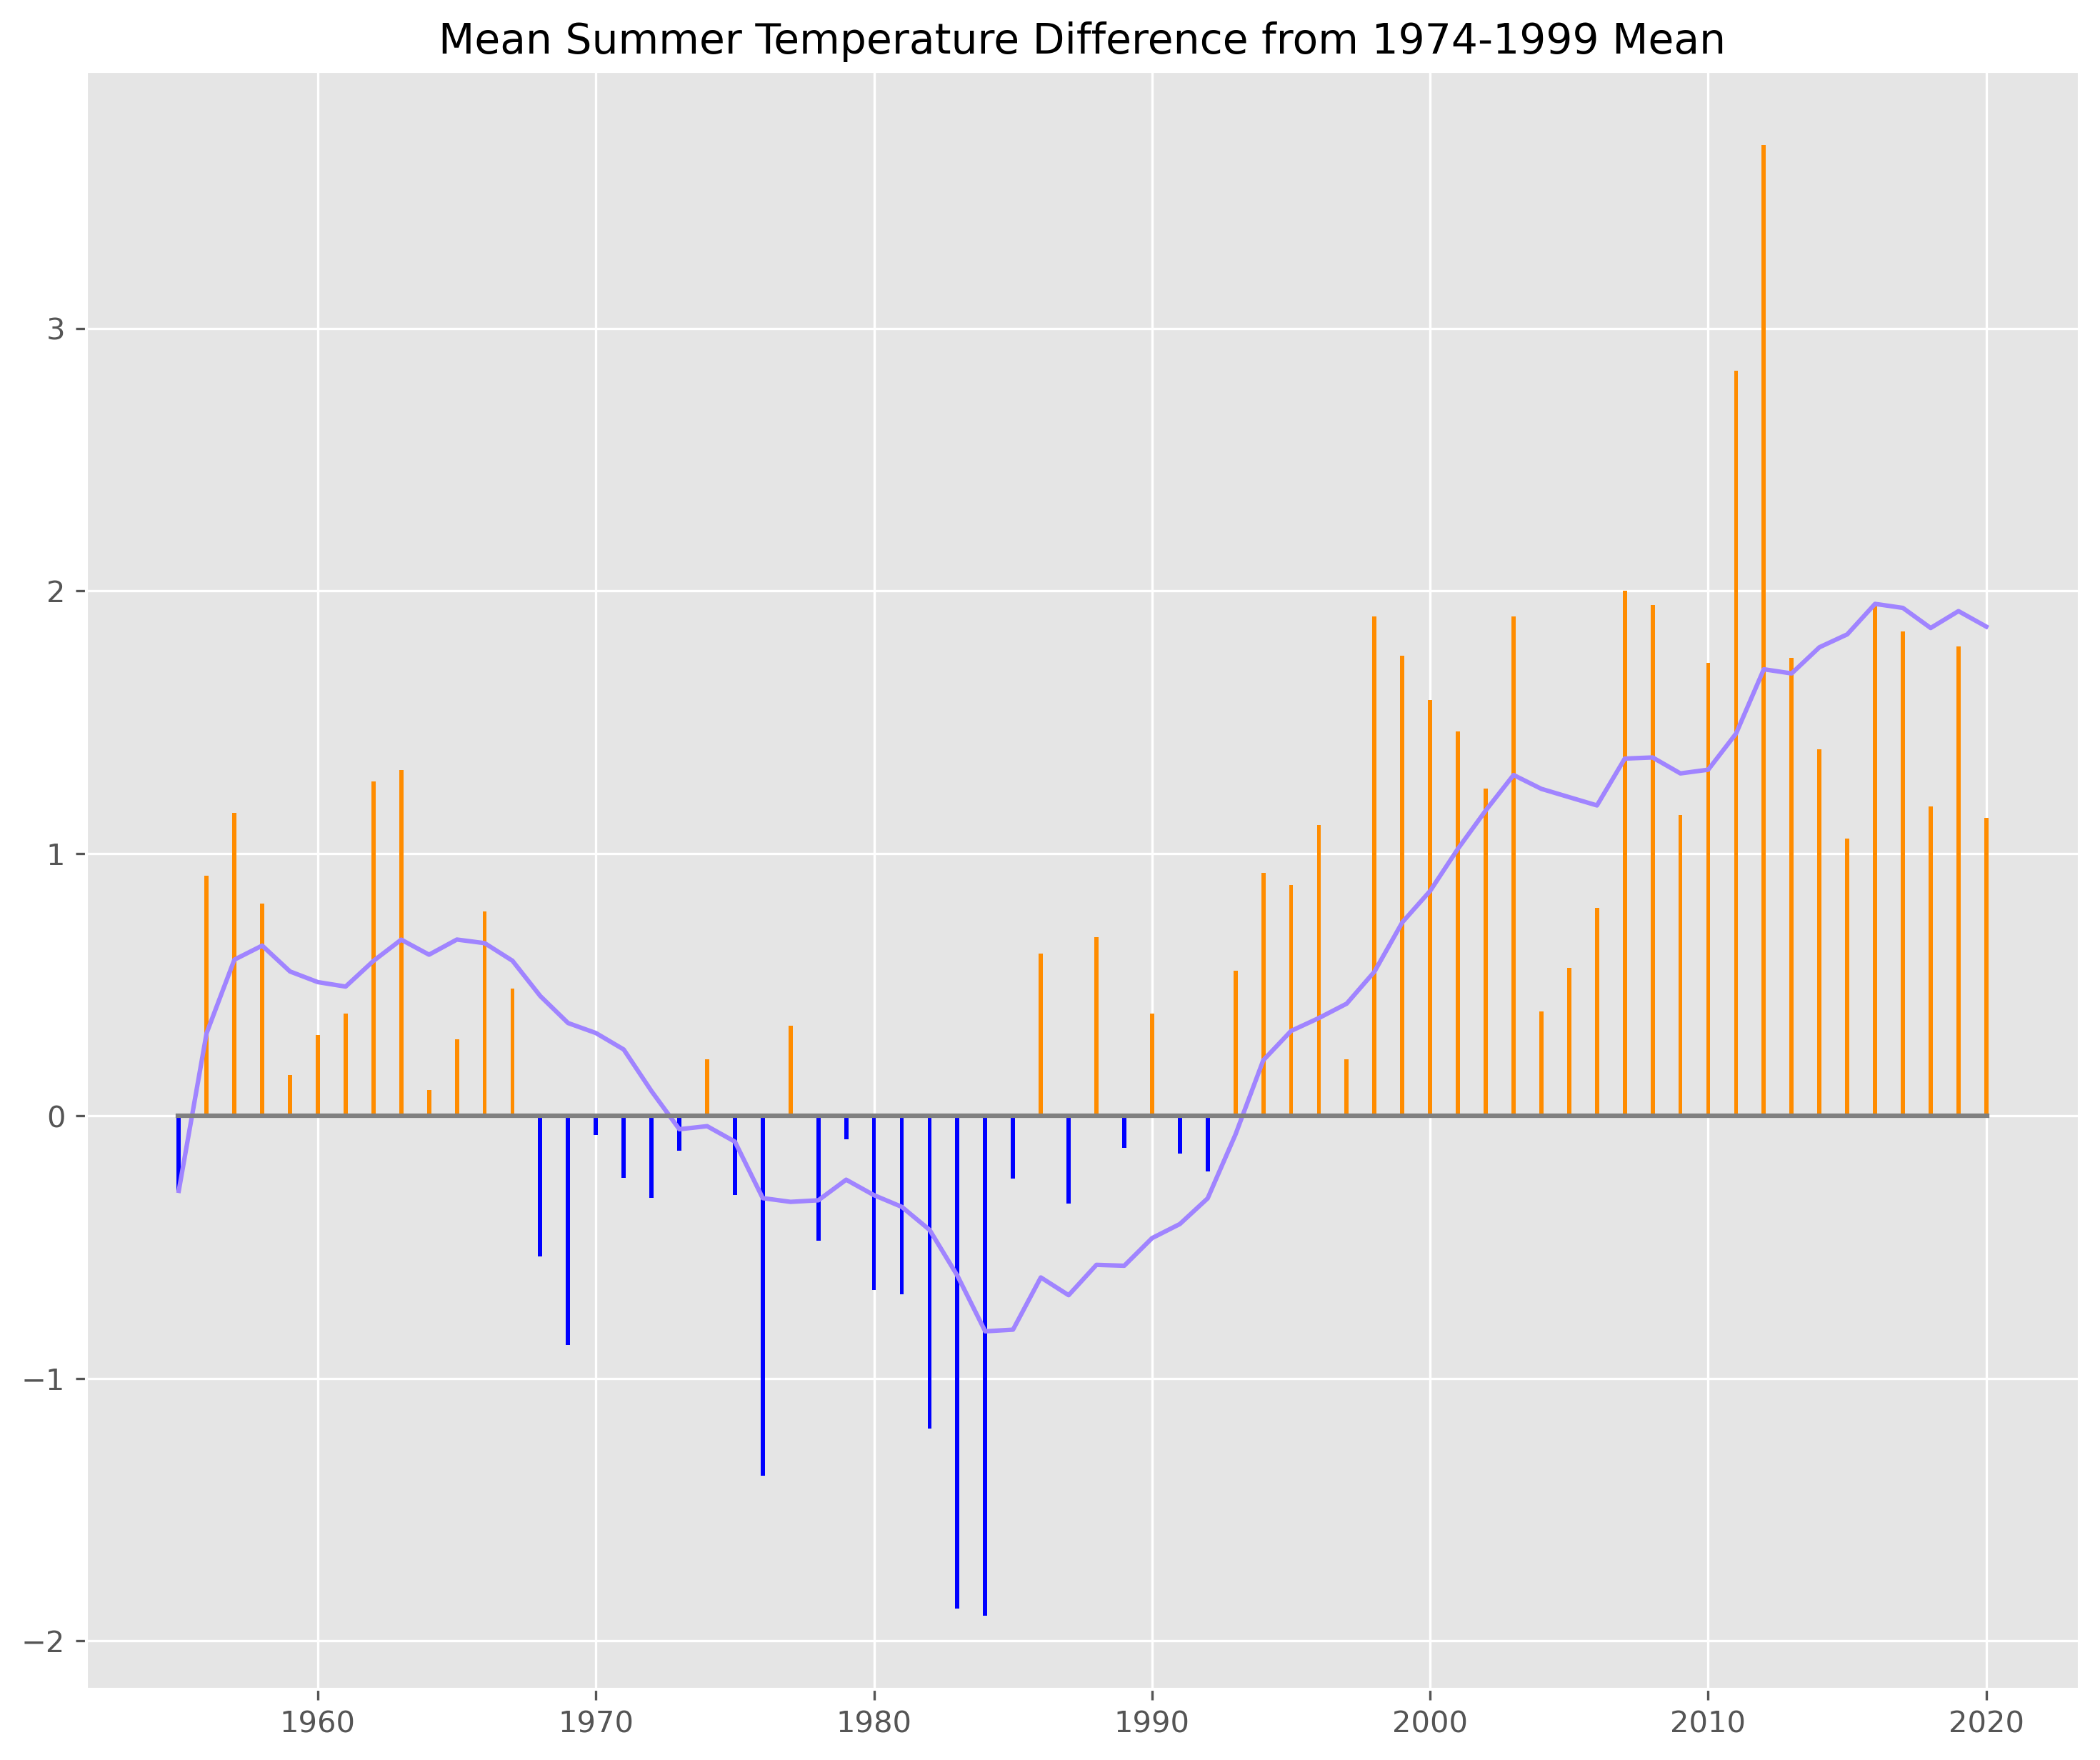

In [5]:
plt.figure(figsize=(12, 10), dpi = 300)
plt.style.use("ggplot")
values = list(summers_avg.deviation)
x = list(summers_avg.year)
colors = ['darkorange' if (x >= 0) else 'blue' for x in values ]
ax = plt.bar(x, values, width=0.15, color = colors)
plt.plot(x, summers_avg.rolling_avg, color='#A084FF')
plt.axhline(0, color='grey', xmin=0.046, xmax=0.954)
plt.title("Mean Summer Temperature Difference from 1974-1999 Mean", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

As we can see from the graph, in the past 25 years the average temperature during the summer season is getting significantly higher than the average from our baseline of 1975-1999, which in hindsight means that the summers are slowly becoming hotter and hotter.

But now let's see how the temperatures are changing throughout the whole year during the past 50+ years. <br />
This time, we looked into the daily average temperature for each year.

In [6]:
all_daily_temp["day"] = all_daily_temp["DATE"].dt.dayofyear
all_daily_temp["rolling"] = all_daily_temp.rolling(30, min_periods=1).mean().TAVG
daily_temp_rolling = all_daily_temp[["DATE", "rolling", "year", "day"]]
daily_temp_rolling_pv = daily_temp_rolling.pivot(index="day", columns="year", values="rolling")
baseline = daily_temp_rolling.loc[(daily_temp_rolling.year>=1974) & (daily_temp_rolling.year<=1999)]
baseline_pv = baseline.pivot(index="day", columns="year", values="rolling")
baseline_pv["mean"] = baseline_pv.mean(axis=1)

The following graph shows the daily temperature throughout the year for each year from 1955 until 2020. 
- The lines are colored from light orange to dark orange, progressing through the years in ascending order. 
- The black line corresponds to the average daily temperature for the baseline period of 1974-1999.
- Each line is smoothed by the 30 days rolling average.

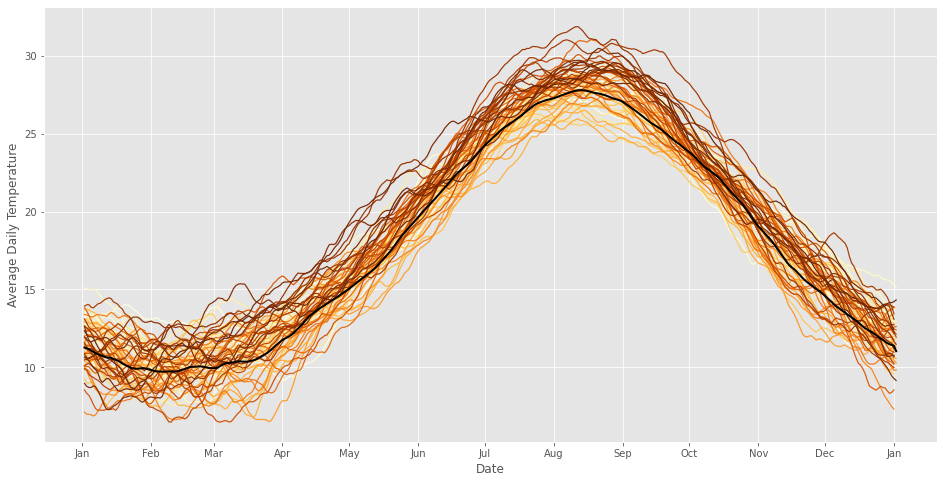

In [7]:
import matplotlib.dates as mdates
import seaborn as sns

plt.figure(figsize=(16, 8))
plt.ylabel("Average Daily Temperature")
plt.xlabel("Date")
sns.lineplot(data=daily_temp_rolling_pv, palette="YlOrBr", dashes=False,linewidth = 1.2, legend=False)
sns.lineplot(data=baseline_pv["mean"], color="#000000", linewidth = 2, dashes=False)
x = plt.gca().xaxis
x.set_major_locator(mdates.MonthLocator())
x.set_major_formatter(mdates.DateFormatter('%b'))

Now we can clearly see that during the summer and also autumn, the temperature is constantly increasing throughout the years, going further and further from the average temperature of our baseline. <br />
However during the other seasons we see that the temperature is relatively close to the average temperature of our baseline, with the lines overlaping one another.

## Extreme Temperature Events

Next we wanted to investigate the number of extreme tempearture events for each year between 1955 and 2020. <br />
- Extreme tempearture events are defined as those beyond 5% or 10% from the expected tempearture. 

In our case we'll assume that extreme heat events are the ones going 10% above our baseline of 1974-1999.

In [8]:
import calendar

bl_daily_temp = all_daily_temp.loc[(all_daily_temp.year>=1974) & (all_daily_temp.year<=1999)].drop(["month", "rolling"], 
                                                                                          axis=1).set_index('DATE')
bl_daily_avg = all_daily_temp.loc[(all_daily_temp.year>=1974) & (all_daily_temp.year<=1999)].groupby("day").mean().drop(["month", "year", "rolling"], axis=1)
bl_daily_avg = bl_daily_avg.reset_index()
bl_daily_temp = bl_daily_temp.merge(bl_daily_avg, on="day", how="left", suffixes=('','_BL'))
bl_daily_temp["extreme_event"] = (bl_daily_temp.TAVG - bl_daily_temp.TAVG_BL) > 0.1*bl_daily_temp.TAVG_BL
baseline_extr_ev_avg = bl_daily_temp.groupby("year").sum().mean().extreme_event
baseline_extr_ev_prc = baseline_extr_ev_avg/365

daily_temps = all_daily_temp.drop(["month", "rolling"], axis=1).set_index('DATE')
daily_temps = daily_temps.merge(bl_daily_avg, on="day", how="left", suffixes=('','_BL'))
daily_temps["extreme_event"] = (daily_temps.TAVG - daily_temps.TAVG_BL) > 0.1*daily_temps.TAVG_BL
annual_extr_events = daily_temps.groupby("year").sum().drop(["day", "TAVG", "TAVG_BL"], axis=1)
annual_extr_events= annual_extr_events.reset_index()
annual_extr_events["is_leap"] = annual_extr_events["year"].apply(calendar.isleap)
annual_extr_events["total_days"] = np.where(annual_extr_events.is_leap, 366, 365)                         
annual_extr_events["percentage"] = annual_extr_events.extreme_event/annual_extr_events.total_days

In the next graph we compare the percentage of total extreme tempearture events for every year with the average percentage of extreme tempearture events of the baseline. 
- The vertical axis is the percentage of extreme heat events calculated over the number of observations for each year.
- The gray line in the middle is the average percentage of extreme tempearture events of the baseline.
- The colour blue is used for those years where the percentage is below the baseline; otherwise the colour is orange.

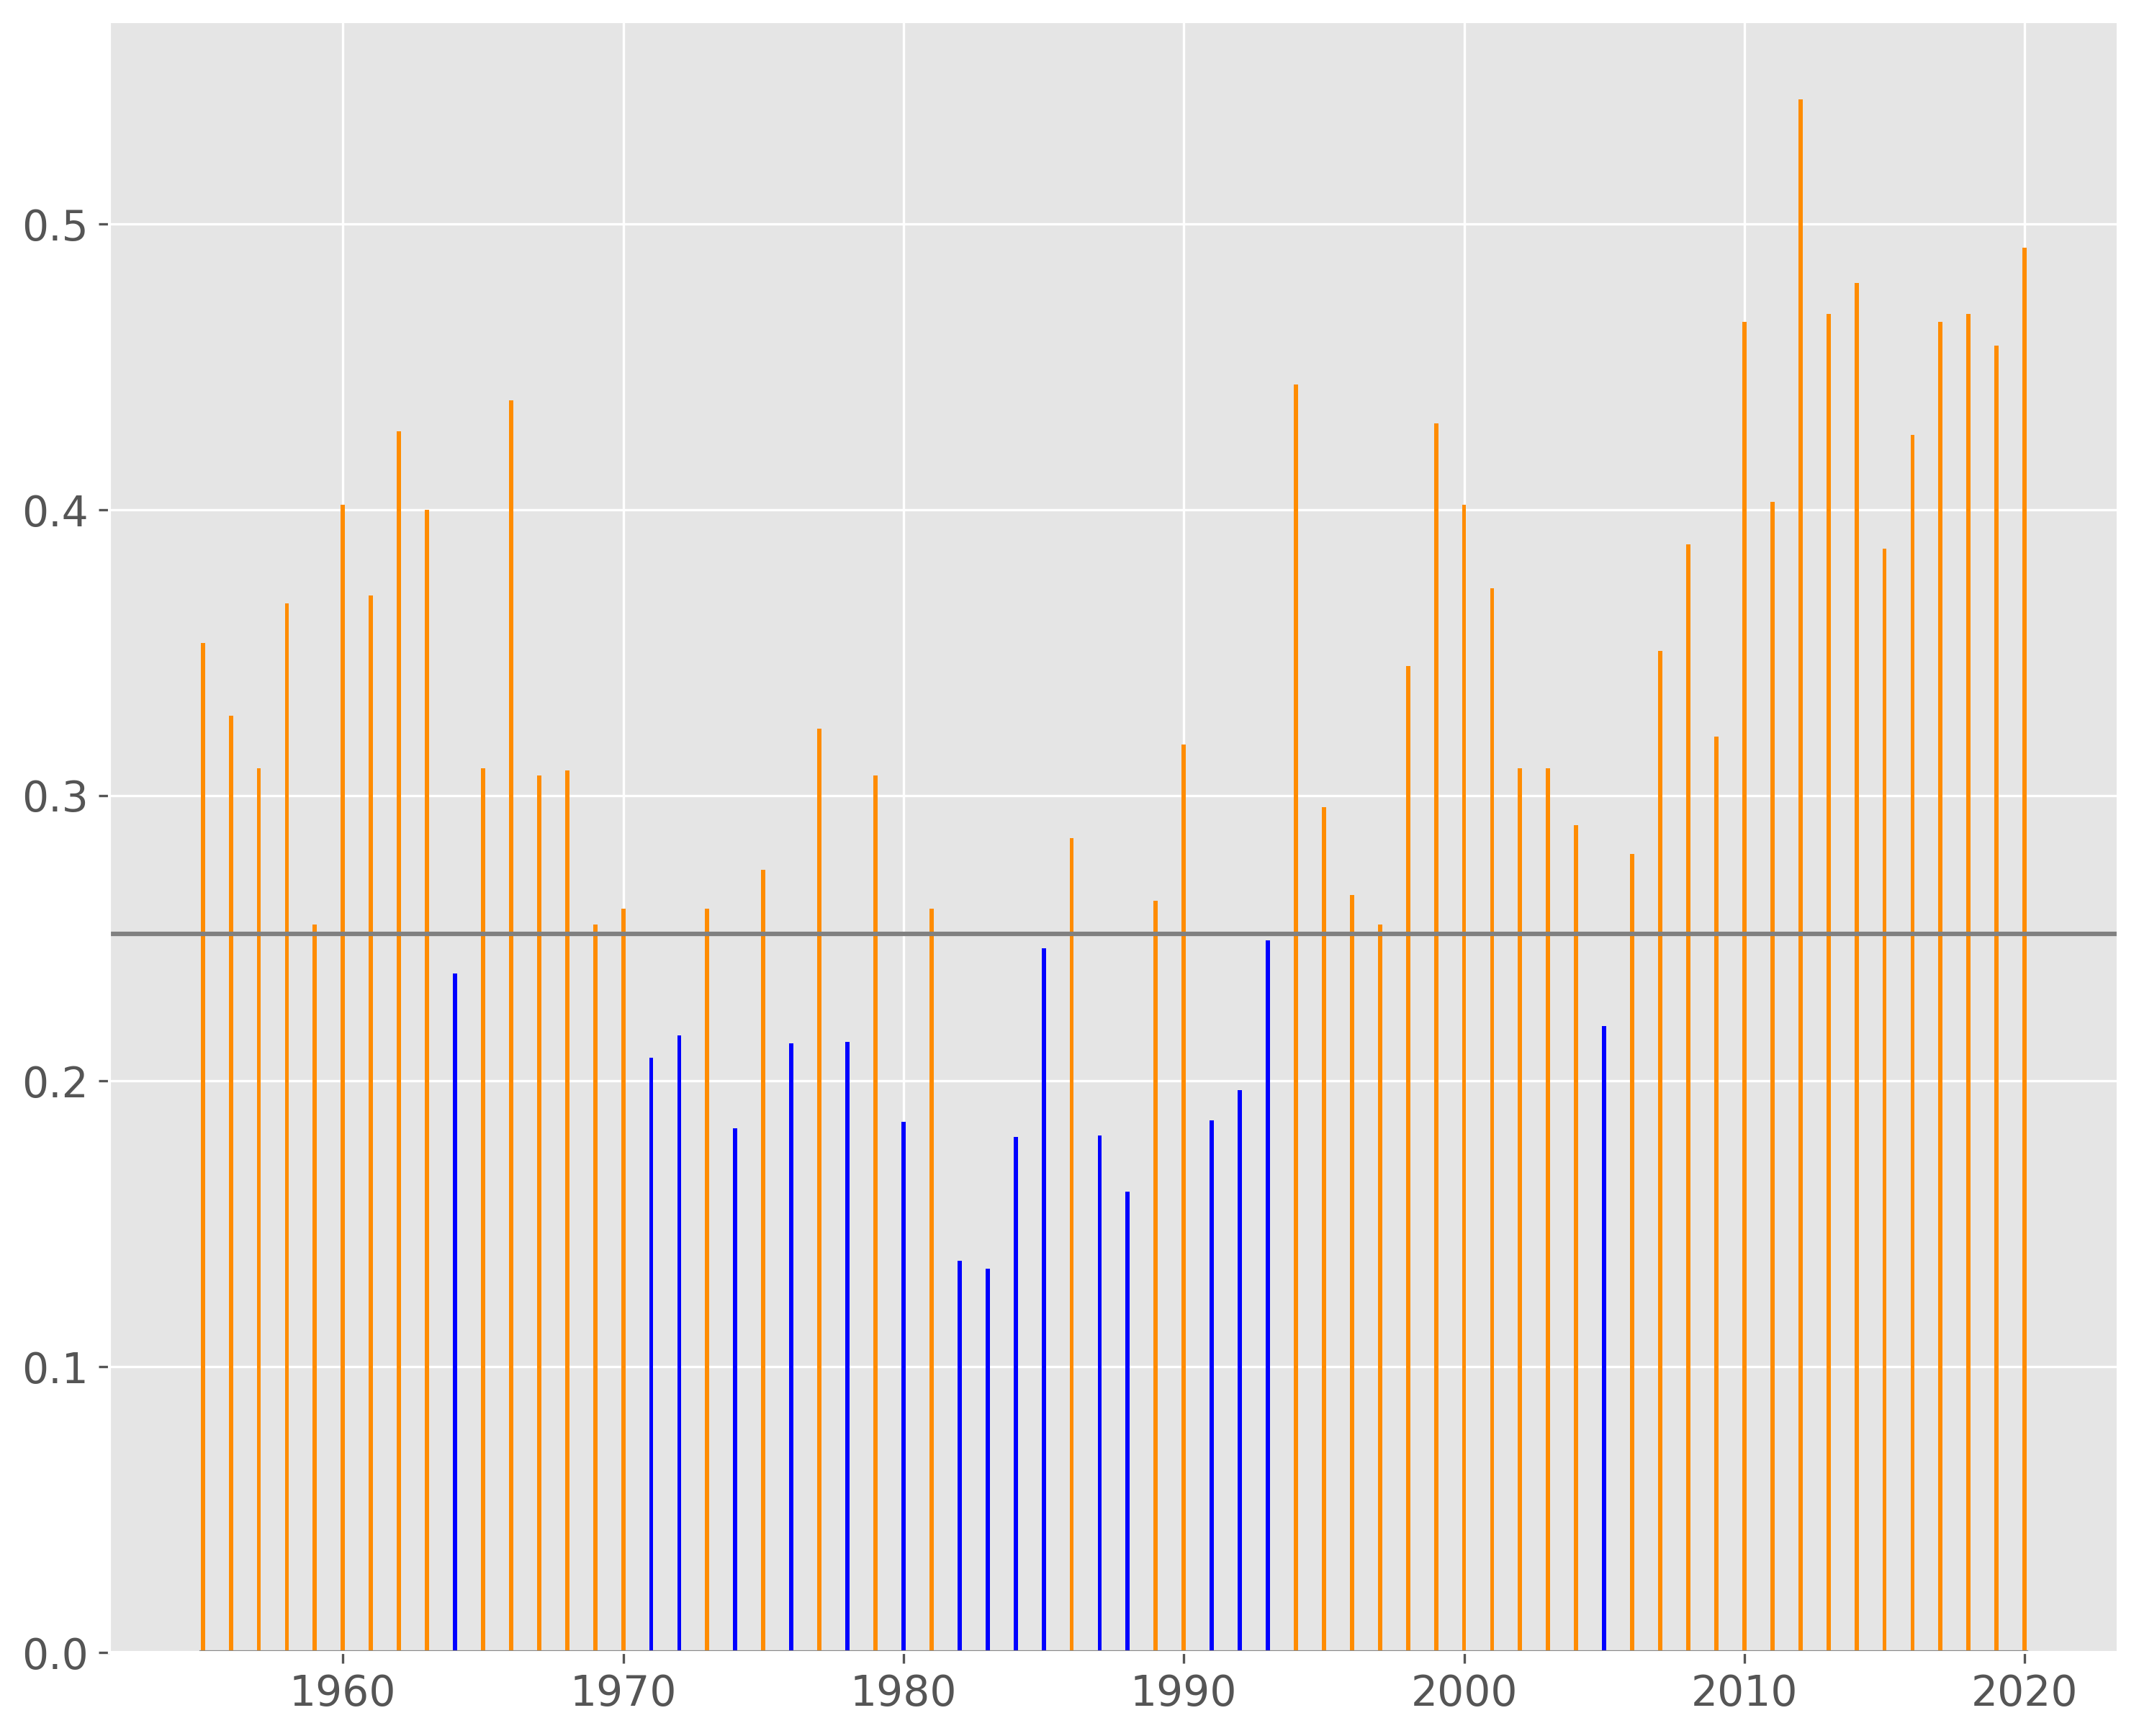

In [9]:
plt.figure(figsize=(12, 10), dpi = 300)
plt.style.use("ggplot")
values = list(annual_extr_events.percentage)
xaxis = list(annual_extr_events.year)
colors = ['darkorange' if (x >= baseline_extr_ev_prc) else 'blue' for x in values ]
ax = plt.bar(xaxis, values, width=0.15, color=colors)
plt.axhline(baseline_extr_ev_prc, color='grey')
plt.axhline(0, color='grey', xmin=0.046, xmax=0.954)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

In this graph, we can clearly see that since 1994, each year (apart from 2005) the percentage of extreme heat events is higher than that of the baseline. <br />

We see that in the last 14 years, the percentage of extreme heat events is consistently over that of the baseline. More specifically, in the last decade, the extreme heat events make up more than 40% of the observations each year, with a significant rise to more than 50% noticed in 2012. That means that in 2012 more than half the days of the year were considered hotter than expected.

## Precipitation

Continuing the thread on extreme events, another consideration is rainfall. The weather may or may not be drying up. We are, however, interested in whether precipication becomes more intense over time. <br />

To see that, we selected the data regarding the precipitation from our datasets and filled in any missing values as before.<br />
- Note that we converted all precipitation amounts to mm (millimeter).

We first counted the overall rainfall over the year and the number of rainy days in each year. Then we divided the rainfall by the number of rainy days to see whether we are getting rain in more concentrated bursts throughout the years.

In [10]:
rain_data1 = data_hel[['DATE','PRCP']].set_index('DATE').rename(columns={"PRCP": "PRCP1"})
rain_data1['PRCP1'] = (rain_data1['PRCP1']*25.4).round(2)
rain_data2 = data2[['DATE','PRCP']].set_index('DATE').rename(columns={"PRCP": "PRCP2"})
rain_data = pd.concat([rain_data1,rain_data2], axis=1)

rain_data.PRCP1.fillna(rain_data.PRCP2, inplace=True)
rain_data = rain_data.drop(['PRCP2'], axis=1).rename(columns={"PRCP1": "rainfall"})
rain_data = rain_data.reset_index()
rain_data["YEAR"] = rain_data['DATE'].dt.year

annual_overall_rainfall = rain_data.groupby('YEAR').sum()
annual_overall_rainfall["rainy_days"] = rain_data.loc[rain_data.rainfall>0].groupby('YEAR').size()
annual_overall_rainfall["ratio"] = annual_overall_rainfall.rainfall / annual_overall_rainfall.rainy_days
annual_overall_rainfall["rolling_avg"] = annual_overall_rainfall.rolling(10, min_periods=1).mean().ratio
annual_overall_rainfall = annual_overall_rainfall.reset_index()

The following plot shows the ratio of rainfall over rainy days over the years. The line that runs through the graph is the 10 years rolling average that ratio.

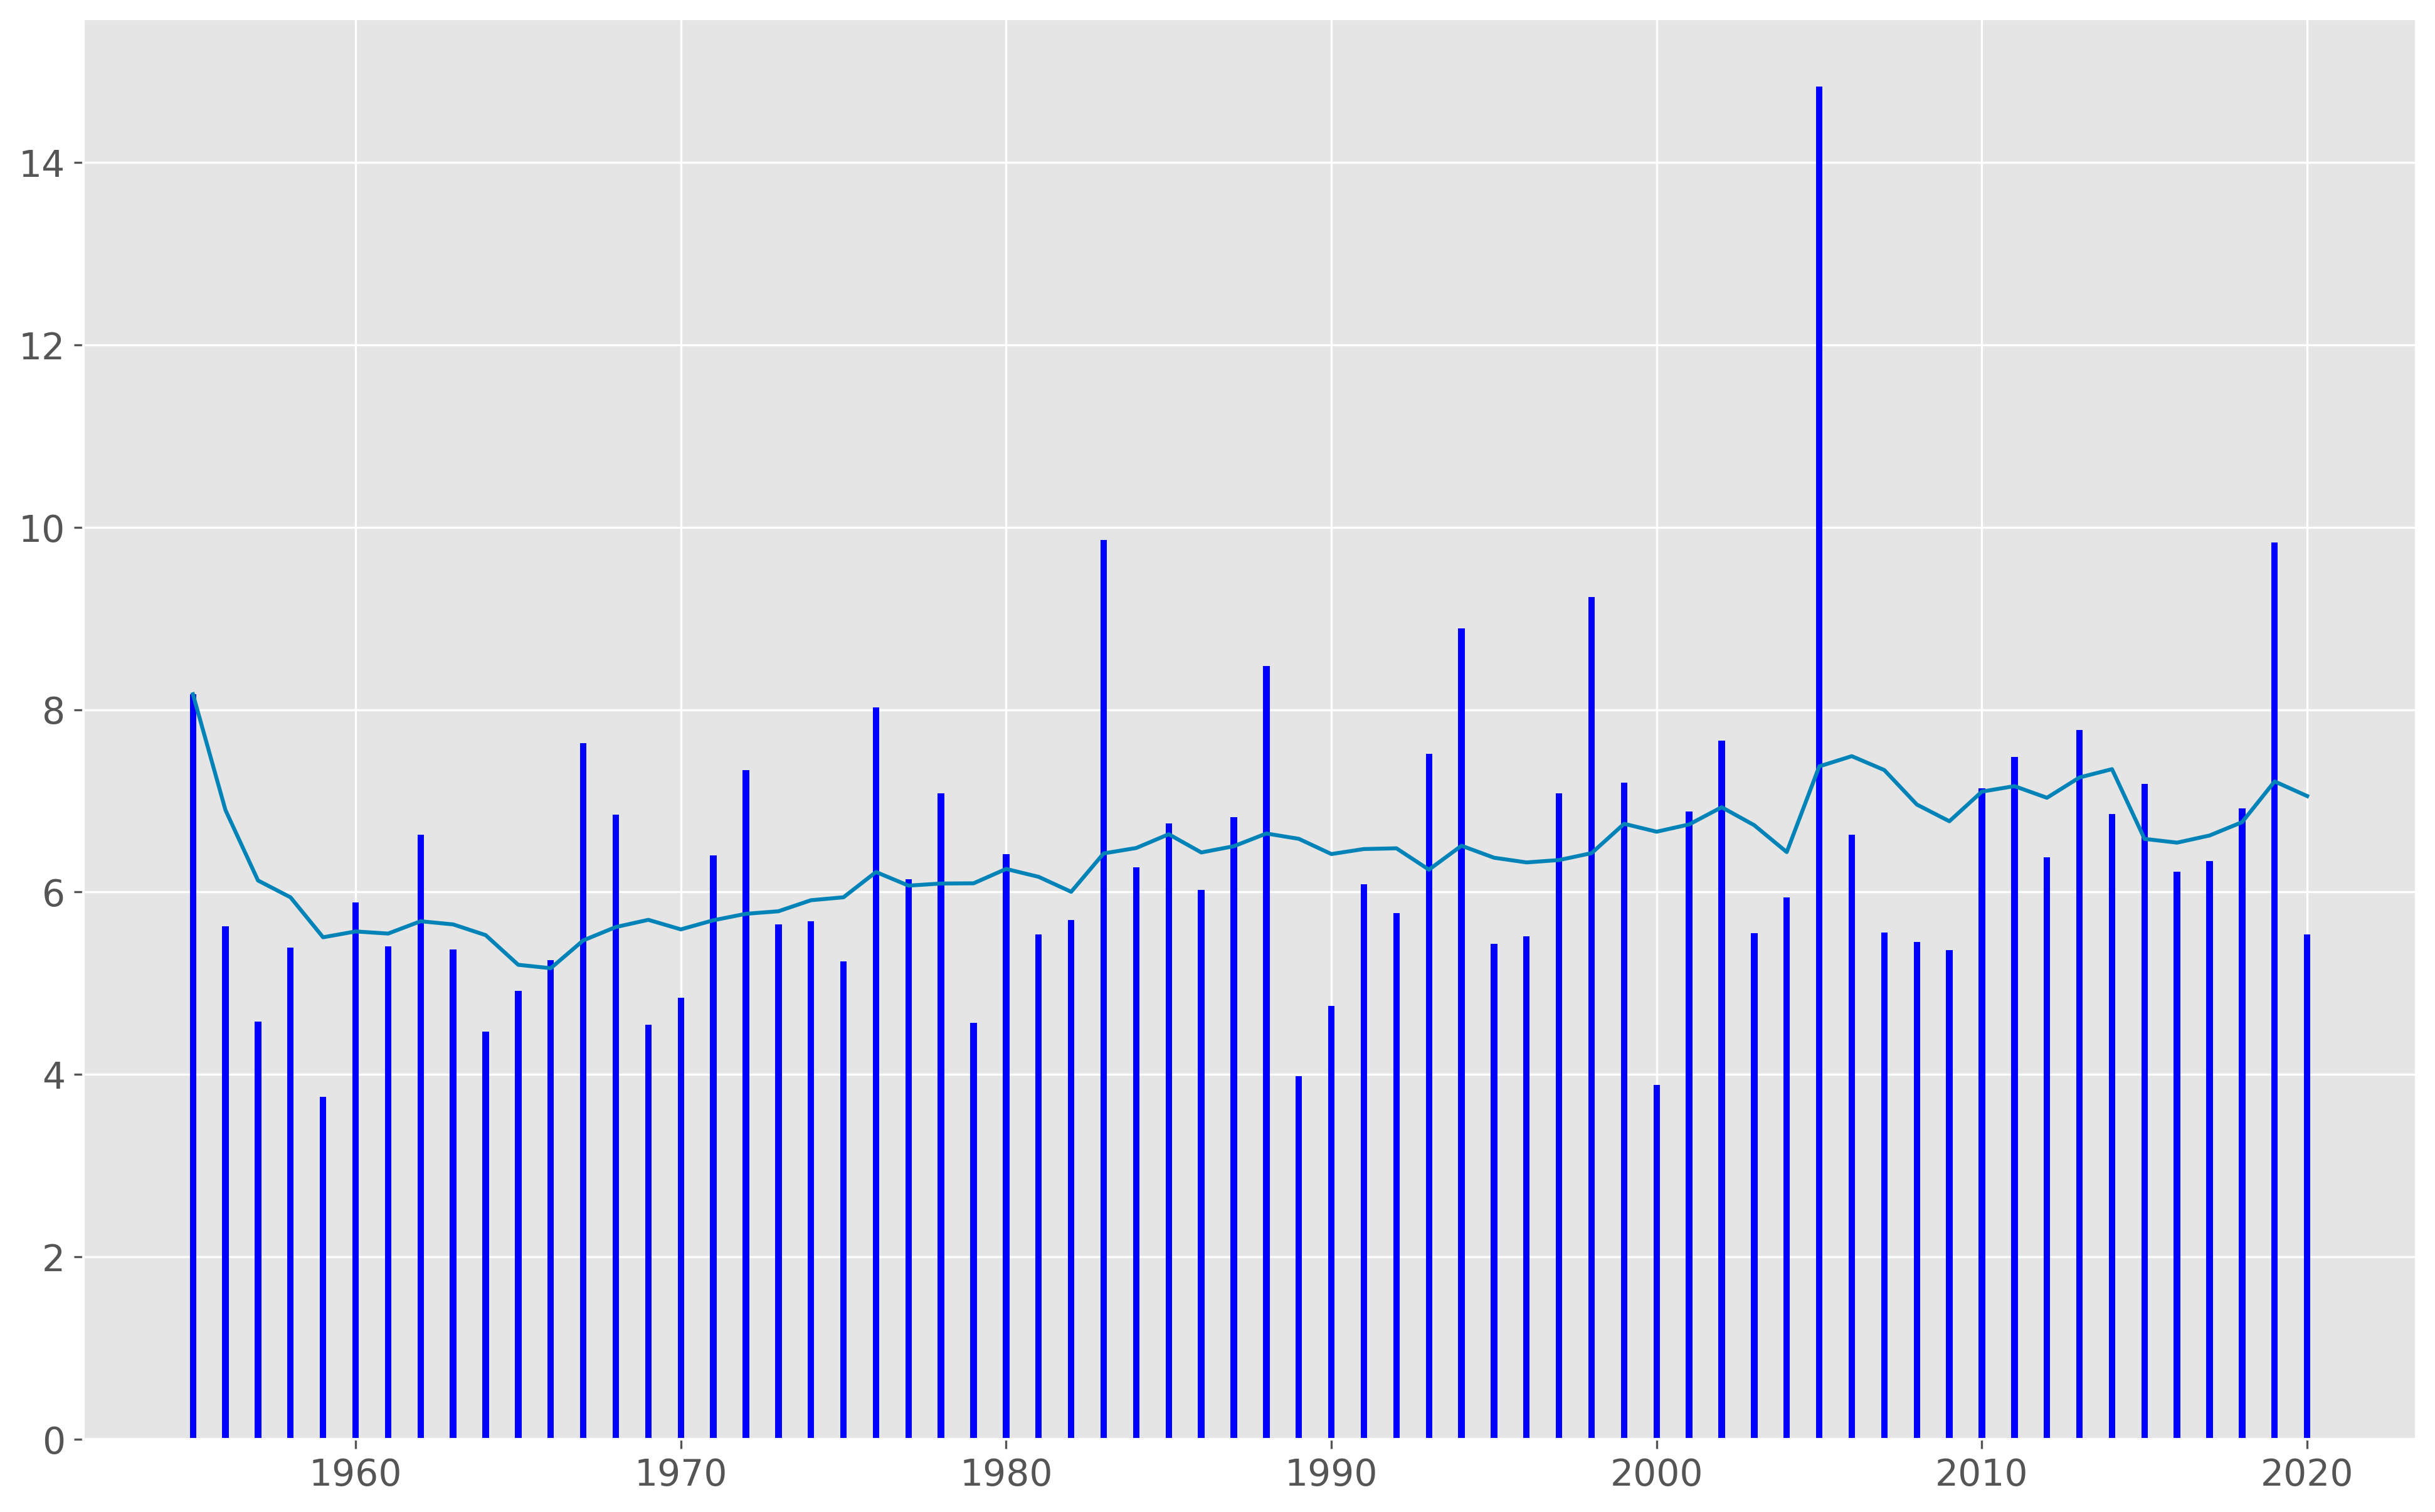

In [11]:
plt.figure(figsize=(16, 10), dpi = 300)
plt.style.use("ggplot")
values = list(annual_overall_rainfall.ratio)
xaxis = list(annual_overall_rainfall.YEAR)
ax = plt.bar(xaxis, values, width=0.2, color='blue')
plt.plot(xaxis, annual_overall_rainfall.rolling_avg, color='#0283B8')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

Lastly, in this plot we notice that in the period of 1955-1995 the ratio of rainfall over rainy days seems to be following a certain pattern. <br />

However, after 1995 that pattern can no longer be noticed. <br/>

We see that certain years, such as 1998, 2005 and 2019 have high ratios and the rest of the years have a lot lower ones. This observation, validates our hypothesis that in the last decade we are getting rain in more concentrated bursts, meaning that in certain years the rainfall is extremely high whereas in between, the rest of the years the rainfall is quite lower.